In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import glob
import random

In [2]:
# Configuration
DATA_ROOT = '/kaggle/input/neural-network-stylegan-real-fake-dataset/output'
REAL_DIR = os.path.join(DATA_ROOT, 'original')
FAKE_DIR = os.path.join(DATA_ROOT, 'augmented')
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Dataset Verification and Loading
print("Verifying dataset paths...")
print(f"Real directory exists: {os.path.exists(REAL_DIR)}")
print(f"Fake directory exists: {os.path.exists(FAKE_DIR)}")

real_paths = glob.glob(os.path.join(REAL_DIR, '*.png'))
fake_paths = glob.glob(os.path.join(FAKE_DIR, '*.png'))

print(f"\nFound {len(real_paths)} real images")
print(f"Found {len(fake_paths)} fake images")

if not real_paths and not fake_paths:
    raise ValueError("No images found in both directories!")

Verifying dataset paths...
Real directory exists: True
Fake directory exists: True

Found 7763 real images
Found 10000 fake images


In [4]:
# 2. Dataset Preprocessing
def compute_fft(image_tensor):
    grayscale = image_tensor.mean(dim=0, keepdim=True)
    fft = torch.fft.fft2(grayscale)
    fft_shifted = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shifted)
    log_magnitude = torch.log1p(magnitude)
    log_magnitude = (log_magnitude - log_magnitude.min()) / (log_magnitude.max() - log_magnitude.min())
    return log_magnitude.squeeze(0)  # Remove channel dimension

class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ]) if transform is None else transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        image = self.transform(image)
        fft = compute_fft(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return (image, fft), label


In [5]:
# 3. Dataset Splitting
all_paths = real_paths + fake_paths
all_labels = [0]*len(real_paths) + [1]*len(fake_paths)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, 
    test_size=0.2, 
    stratify=all_labels,
    random_state=42,
    shuffle=True
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print(f"\nDataset splits:")
print(f"Train: {len(train_paths)} samples")
print(f"Validation: {len(val_paths)} samples")
print(f"Test: {len(test_paths)} samples")


Dataset splits:
Train: 14210 samples
Validation: 1776 samples
Test: 1777 samples


In [6]:
# 4. Model Architecture
class DualStreamModel(nn.Module):
    def __init__(self):
        super(DualStreamModel, self).__init__()
        # RGB Stream (efficient net)
        self.rgb_stream = models.efficientnet_b4(pretrained=True)
        self.rgb_stream.classifier = nn.Identity()
        
        # Frequency Stream (Custom CNN)
        self.freq_stream = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1792 + 128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, rgb, freq):
        # RGB features
        rgb_features = self.rgb_stream(rgb).flatten(1)
        
        # Frequency features
        freq = freq.unsqueeze(1)  # Add channel dimension
        freq_features = self.freq_stream(freq).flatten(1)
        
        # Combined classification
        combined = torch.cat([rgb_features, freq_features], dim=1)
        return self.classifier(combined).squeeze()


In [7]:
# 5. Data Loaders
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = DeepfakeDataset(train_paths, train_labels, train_transform)
val_dataset = DeepfakeDataset(val_paths, val_labels, val_transform)
test_dataset = DeepfakeDataset(test_paths, test_labels, val_transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [8]:
# 6. Training Setup
model = DualStreamModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCELoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 91.3MB/s]


In [9]:
# 7. Training Loop with Early Stopping
best_val_acc = 0.0
patience = 5  # Number of epochs to wait before stopping
no_improve = 0  # Counter for epochs without improvement
min_delta = 0.001  # Minimum improvement to consider as progress
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    for (rgb, fft), labels in train_loader:
        rgb, fft, labels = rgb.to(DEVICE), fft.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(rgb, fft)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for (rgb, fft), labels in val_loader:
            rgb, fft, labels = rgb.to(DEVICE), fft.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(rgb, fft)
            val_loss += criterion(outputs, labels).item() * labels.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Calculate metrics
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping logic
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Validation improved! Saving model...")
    else:
        no_improve += 1
        print(f"No improvement for {no_improve}/{patience} epochs")
    
    # Check early stopping condition
    if no_improve >= patience:
        print(f"\nEarly stopping triggered after {patience} epochs without improvement!")
        break

# After training completes
if epoch == EPOCHS - 1:
    print("\nCompleted all epochs without early stopping")
else:
    print(f"\nTraining stopped early at epoch {epoch+1}")


Epoch 1/20
Train Loss: 0.5830 | Train Acc: 0.6753
Val Loss: 0.3736 | Val Acc: 0.8311
Validation improved! Saving model...

Epoch 2/20
Train Loss: 0.2582 | Train Acc: 0.8928
Val Loss: 0.2047 | Val Acc: 0.9167
Validation improved! Saving model...

Epoch 3/20
Train Loss: 0.1346 | Train Acc: 0.9482
Val Loss: 0.1530 | Val Acc: 0.9459
Validation improved! Saving model...

Epoch 4/20
Train Loss: 0.0927 | Train Acc: 0.9659
Val Loss: 0.1314 | Val Acc: 0.9538
Validation improved! Saving model...

Epoch 5/20
Train Loss: 0.0643 | Train Acc: 0.9758
Val Loss: 0.1315 | Val Acc: 0.9555
Validation improved! Saving model...

Epoch 6/20
Train Loss: 0.0537 | Train Acc: 0.9811
Val Loss: 0.1089 | Val Acc: 0.9657
Validation improved! Saving model...

Epoch 7/20
Train Loss: 0.0463 | Train Acc: 0.9835
Val Loss: 0.0991 | Val Acc: 0.9617
No improvement for 1/5 epochs

Epoch 8/20
Train Loss: 0.0359 | Train Acc: 0.9878
Val Loss: 0.0825 | Val Acc: 0.9685
Validation improved! Saving model...

Epoch 9/20
Train Loss:

In [10]:
# 8. Model Evaluation and Visualization
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Create test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

# Get predictions for entire test set
all_preds = []
all_labels = []
with torch.no_grad():
    for (rgb, fft), labels in test_loader:
        rgb, fft = rgb.to(DEVICE), fft.to(DEVICE)
        outputs = model(rgb, fft)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


<ipython-input-10-4d4dce01b88e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


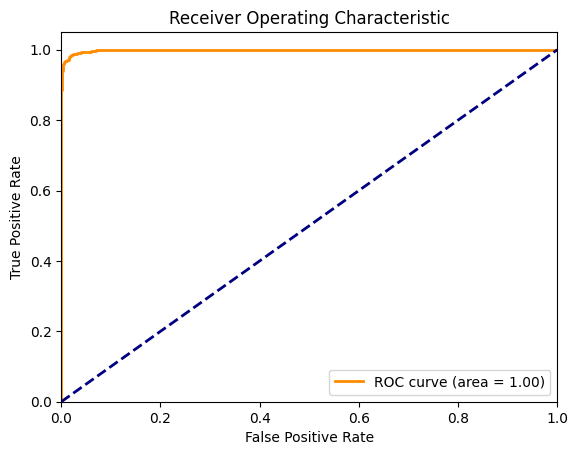

In [11]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

In [12]:
# Generate Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, 
                           [1 if p > 0.5 else 0 for p in all_preds],
                           target_names=['Real', 'Fake']))


Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98       777
        Fake       0.98      0.98      0.98      1000

    accuracy                           0.98      1777
   macro avg       0.98      0.98      0.98      1777
weighted avg       0.98      0.98      0.98      1777



In [13]:
# Save Final Model
torch.save(model.state_dict(), 'final_DualStream_EfficientNet+CNN_model.pth')
print("\nModel saved as 'final_model.pth'")


Model saved as 'final_model.pth'


In [14]:
# 9. Random Image Predictions
def predict_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension
    fft = compute_fft(image_tensor.squeeze(0))  # Remove batch dim for FFT
    fft = fft.unsqueeze(0).to(DEVICE)  # Add batch dimension back
    
    with torch.no_grad():
        output = model(image_tensor, fft)
        prob = output.item()
    
    return "Fake" if prob > 0.5 else "Real", prob

In [15]:
# Get 5 random samples from test set
print("\nRandom Test Predictions:")
random_images = random.sample(test_paths, 5)
for img_path in random_images:
    pred, prob = predict_image(img_path)
    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Prediction: {pred}")
    print(f"Confidence: {prob:.4f}")
    print("Actual:", "Fake" if "augmented" in img_path else "Real")
    print("-" * 50)


Random Test Predictions:

Image: orig_00218.png
Prediction: Real
Confidence: 0.0000
Actual: Real
--------------------------------------------------

Image: aug_04782.png
Prediction: Fake
Confidence: 1.0000
Actual: Fake
--------------------------------------------------

Image: orig_02773.png
Prediction: Real
Confidence: 0.4281
Actual: Real
--------------------------------------------------

Image: orig_00796.png
Prediction: Real
Confidence: 0.0000
Actual: Real
--------------------------------------------------

Image: orig_06308.png
Prediction: Real
Confidence: 0.0000
Actual: Real
--------------------------------------------------
